In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


정책효과 O


📌 데이터 확인
         월        총승객수     city    month  activation month_str  treat  post  \
0  2023-06  18580072.0  Incheon  2023-06         0.0   2023-06      0     0   
1  2023-07  17918345.0  Incheon  2023-07         0.0   2023-07      0     0   
2  2023-08  17657789.0  Incheon  2023-08         0.0   2023-08      0     0   
3  2023-09  18193303.0  Incheon  2023-09         0.0   2023-09      0     0   
4  2023-10  19167015.0  Incheon  2023-10         0.0   2023-10      0     0   

   did  
0    0  
1    0  
2    0  
3    0  
4    0  

📌 Parallel Trend Test Result
                            OLS Regression Results                            
Dep. Variable:                   총승객수   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     1042.
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           1.85e-19
Time:                        07:02:4

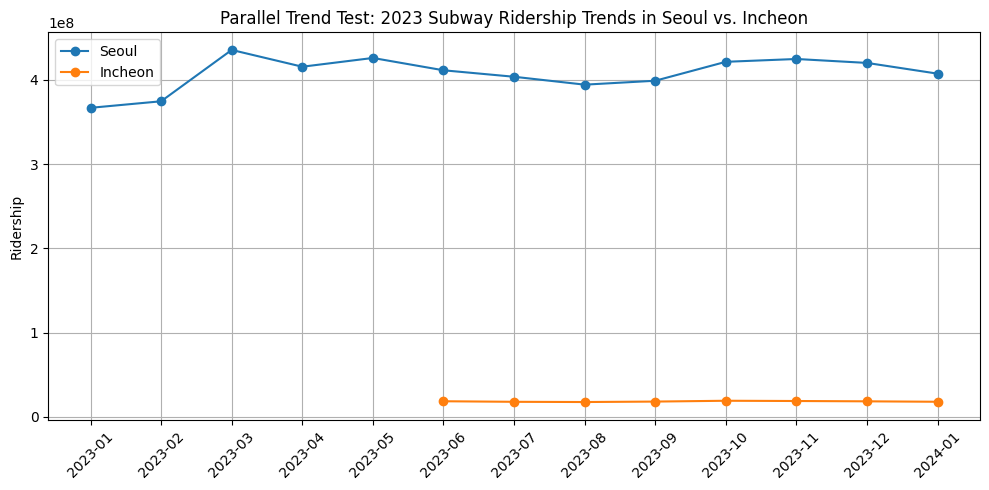


📌 DID 회귀 분석 결과(정책강도 포함)
                            OLS Regression Results                            
Dep. Variable:                   총승객수   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     208.2
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           1.29e-10
Time:                        07:02:41   Log-Likelihood:                -624.87
No. Observations:                  37   AIC:                             1304.
Df Residuals:                      10   BIC:                             1347.
Df Model:                          26                                         
Covariance Type:                  HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
I

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 31, but rank is 26
  warnings.warn('covariance of constraints does not have full '


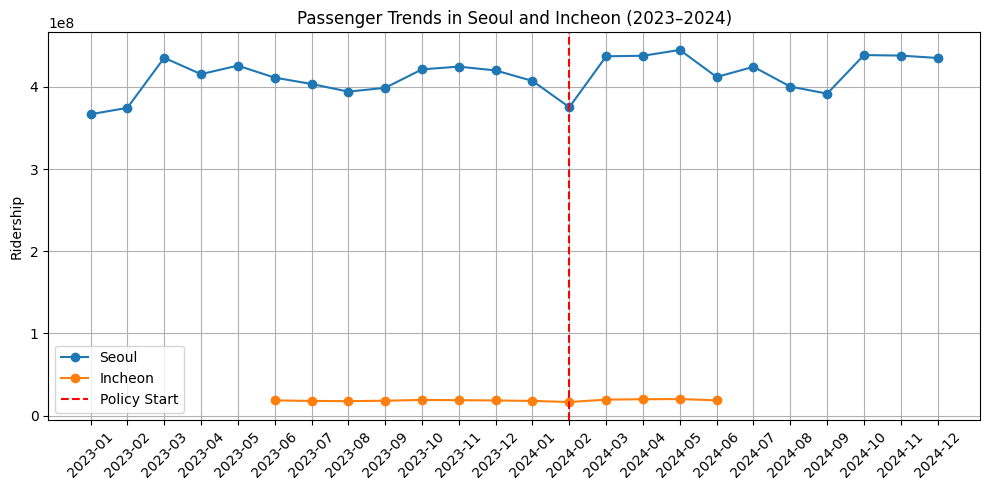

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# ============================================================
# 1️⃣ 데이터 불러오기
# ============================================================
seoul = pd.read_csv("/content/drive/MyDrive/data/seoul_subway_merged.csv")
incheon = pd.read_csv("/content/drive/MyDrive/data/incheon_subway_merged.csv")
card = pd.read_excel("/content/drive/MyDrive/data/기후동행카드 활성화카드 추이.xlsx")

# 필요한 칼럼만 선택
seoul = seoul[['월', '총승객수']].copy()
incheon = incheon[['월', '총승객수']].copy()
card = card[['월', '카드수(만장)']].copy()
card.rename(columns={'카드수(만장)': 'activation'}, inplace=True)

# 도시 구분
seoul['city'] = "Seoul"
incheon['city'] = "Incheon"

# ============================================================
# 2️⃣ 기후동행카드 데이터 병합
# ============================================================
df = pd.concat([seoul, incheon], ignore_index=True)

df['month'] = pd.to_datetime(df['월']).dt.to_period('M')
card['month'] = pd.to_datetime(card['월']).dt.to_period('M')

# 월 단위 병합
df = df.merge(card[['month', 'activation']], on='month', how='left')

# 인천 → 활성화 없음
df.loc[df['city']=='Incheon', 'activation'] = 0

# 결측값 0 대체
df['activation'] = df['activation'].fillna(0)

# character month
df['month_str'] = df['month'].astype(str)

# ============================================================
# 3️⃣ DID 변수 생성
# ============================================================
df['treat'] = (df['city']=="Seoul").astype(int)
df['post'] = (df['month'] >= pd.Period('2024-02')).astype(int)  # 카드 도입월 기준
df['did'] = df['treat'] * df['post']

df = df.sort_values(['city', 'month']).reset_index(drop=True)

print("\n📌 데이터 확인")
print(df.head())

# ============================================================
# 4️⃣ 평행추세 검정 (2023년만)
# ============================================================
pre = df[df['post']==0].copy()
pre['time_index'] = pre.groupby('city').cumcount()

pt_model = smf.ols("총승객수 ~ time_index + treat:time_index + C(city)", data=pre).fit()
print("\n📌 Parallel Trend Test Result")
print(pt_model.summary())

# 시각화
plt.figure(figsize=(10,5))
for city in ['Seoul','Incheon']:
    tmp = pre[pre['city']==city]
    plt.plot(tmp['month_str'], tmp['총승객수'], marker='o', label=city)
plt.title("Parallel Trend Test: 2023 Subway Ridership Trends in Seoul vs. Incheon")
plt.xticks(rotation=45)
plt.ylabel("Ridership")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# 5️⃣ DID 회귀: 정책강도 포함
# (핵심 정책효과 = treat*post*activation)
# ============================================================
formula = "총승객수 ~ treat*post*activation + C(month_str) + C(city)"
did_model = smf.ols(formula, data=df).fit(cov_type='HC3')

print("\n📌 DID 회귀 분석 결과(정책강도 포함)")
print(did_model.summary())

print("\n🎯 정책강도 기반 DID 핵심효과")
coef = did_model.params['treat:post:activation']
se = did_model.bse['treat:post:activation']
t_val = did_model.tvalues['treat:post:activation']
p_val = did_model.pvalues['treat:post:activation']

print(f"• 계수: {coef:,.0f}")
print(f"• Robust 표준오차: {se:,.0f}")
print(f"• t값: {t_val:.3f}")
print(f"• p값: {p_val:.3f}")

# ============================================================
# 6️⃣ 시각화
# ============================================================
plt.figure(figsize=(10,5))
for city in ['Seoul','Incheon']:
    tmp = df[df['city']==city]
    plt.plot(tmp['month_str'], tmp['총승객수'], marker='o', label=city)

plt.axvline('2024-02', color='red', linestyle='--', label='Policy Start')
plt.title("Passenger Trends in Seoul and Incheon (2023–2024)")
plt.xticks(rotation=45)
plt.ylabel("Ridership")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

개선

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf

# Activation 표준화 (정책강도 개선)
df['activation_std'] = (df['activation'] - df['activation'].mean()) / df['activation'].std()

# 선형 시간추세 변수
df['time_index'] = range(len(df))

# DID 모델 (불필요한 상호작용 제거 + 추세 통제)
model = smf.ols(
    '총승객수 ~ treat + post + activation_std \
     + treat:post:activation_std \
     + time_index',
    data=df
).fit(cov_type='HC3')

print(model.summary())

# DID 핵심계수 추출
did_coef = model.params['treat:post:activation_std']
did_se = model.bse['treat:post:activation_std']
t_value = did_coef / did_se
p_value = model.pvalues['treat:post:activation_std']

did_coef, did_se, t_value, p_value


                            OLS Regression Results                            
Dep. Variable:                   총승객수   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2675.
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           7.12e-40
Time:                        07:02:42   Log-Likelihood:                -664.98
No. Observations:                  37   AIC:                             1342.
Df Residuals:                      31   BIC:                             1352.
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

(np.float64(56674477.89195688),
 np.float64(162194913.73195046),
 np.float64(0.3494220415913861),
 np.float64(0.7267724881253866))

정책효과 X


📌 Parallel Trend 검정 결과
                            OLS Regression Results                            
Dep. Variable:                   총승객수   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     868.1
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           4.94e-17
Time:                        07:02:42   Log-Likelihood:                -339.95
No. Observations:                  19   AIC:                             687.9
Df Residuals:                      15   BIC:                             691.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept       

/tmp/ipython-input-118986976.py:64: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-118986976.py:64: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-118986976.py:64: UserWarning: Glyph 49849 (\N{HANGUL SYLLABLE SEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-118986976.py:64: UserWarning: Glyph 44061 (\N{HANGUL SYLLABLE GAEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-118986976.py:64: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: G

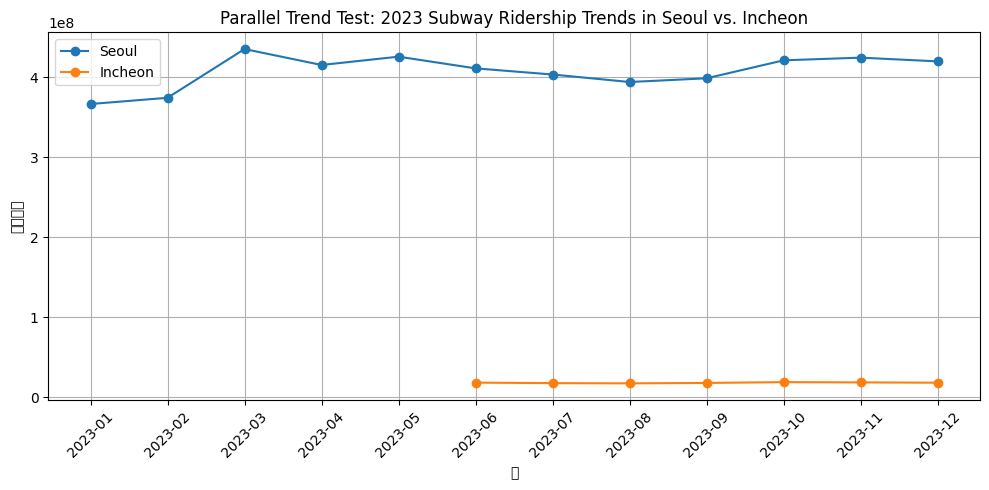


📌 DID 회귀 분석 결과
                            OLS Regression Results                            
Dep. Variable:                   총승객수   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.082e+04
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           6.40e-21
Time:                        07:02:42   Log-Likelihood:                -637.04
No. Observations:                  37   AIC:                             1326.
Df Residuals:                      11   BIC:                             1368.
Df Model:                          25                                         
Covariance Type:                  HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept 

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 26, but rank is 25
  warnings.warn('covariance of constraints does not have full '
/tmp/ipython-input-118986976.py:96: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-118986976.py:96: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-118986976.py:96: UserWarning: Glyph 49849 (\N{HANGUL SYLLABLE SEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-118986976.py:96: UserWarning: Glyph 44061 (\N{HANGUL SYLLABLE GAEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-118986976.py:96: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packag

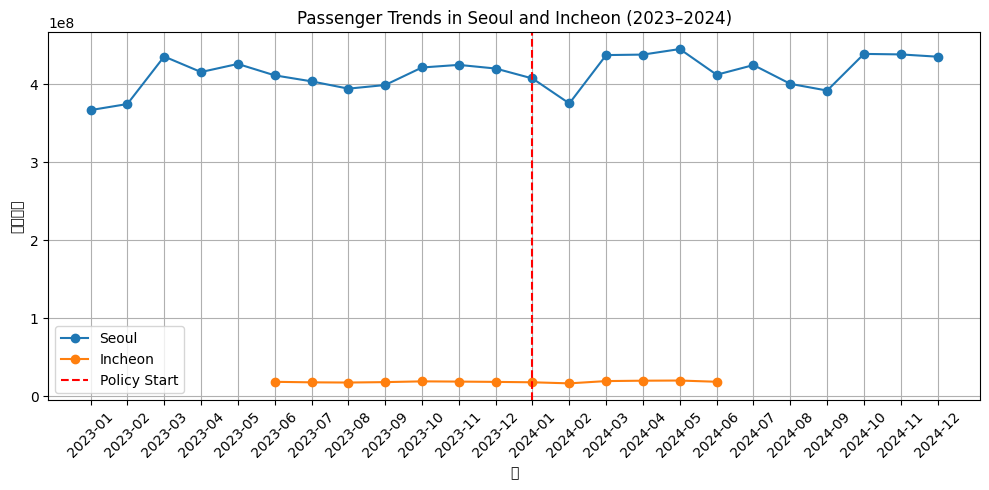

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# ============================================================
# 1️⃣ 데이터 불러오기 및 전처리
# ============================================================
seoul = pd.read_csv("/content/drive/MyDrive/data/seoul_subway_merged.csv")
incheon = pd.read_csv("/content/drive/MyDrive/data/incheon_subway_merged.csv")

# 필요한 컬럼만 선택
seoul = seoul[['월', '총승객수']].copy()
incheon = incheon[['월', '총승객수']].copy()

# 도시 구분
seoul['city'] = "Seoul"
incheon['city'] = "Incheon"

# 합치기
df = pd.concat([seoul, incheon], ignore_index=True)

# 월 컬럼 datetime / Period 변환
df['month'] = pd.to_datetime(df['월']).dt.to_period('M')
df['month_str'] = df['month'].astype(str)

# ============================================================
# 2️⃣ DID 변수 생성
# ============================================================
# 처리집단: 서울=1, 인천=0
df['treat'] = (df['city'] == "Seoul").astype(int)

# 정책 시행: 2024-01부터 =1
df['post'] = (df['month'] >= pd.Period('2024-01')).astype(int)

# DID 상호작용
df['did'] = df['treat'] * df['post']

# 패널 정렬
df = df.sort_values(['city', 'month']).reset_index(drop=True)

# ============================================================
# 3️⃣ Parallel Trend 검정 (정책 이전: 2023년)
# ============================================================
pre = df[df['post'] == 0].copy()  # 2023년만
pre = pre.sort_values(['city', 'month']).reset_index(drop=True)
pre['time_index'] = pre.groupby('city').cumcount()

# 최소회귀 검정
pt_model = smf.ols("총승객수 ~ time_index + treat:time_index + C(city)", data=pre).fit()
print("\n📌 Parallel Trend 검정 결과")
print(pt_model.summary())

# 시각화
plt.figure(figsize=(10,5))
for city_name in ['Seoul', 'Incheon']:
    city_df = pre[pre['city'] == city_name]
    plt.plot(city_df['month_str'], city_df['총승객수'], marker='o', label=city_name)
plt.title("Parallel Trend Test: 2023 Subway Ridership Trends in Seoul vs. Incheon")
plt.xlabel("월")
plt.ylabel("총승객수")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 4️⃣ DID 회귀분석
# ============================================================
formula = "총승객수 ~ post + did + C(month_str) + C(city)"
did_model = smf.ols(formula=formula, data=df).fit(cov_type='HC3')

print("\n📌 DID 회귀 분석 결과")
print(did_model.summary())
print("\n🎯 DID 정책효과 (did 계수): {:.0f}".format(did_model.params['did']))
print("📎 Robust 표준오차:", did_model.bse['did'])
print("📌 정책효과 t값:", did_model.tvalues['did'])
print("📌 정책효과 p값:", did_model.pvalues['did'])

# ============================================================
# 5️⃣ 정책 효과 시각화 (2023~2024)
# ============================================================
plt.figure(figsize=(10,5))
for city_name in ['Seoul', 'Incheon']:
    city_df = df[df['city'] == city_name]
    plt.plot(city_df['month_str'], city_df['총승객수'], marker='o', label=city_name)

# 정책 시행 시점 표시
plt.axvline('2024-01', color='red', linestyle='--', label='Policy Start')
plt.title("Passenger Trends in Seoul and Incheon (2023–2024)")
plt.xlabel("월")
plt.ylabel("총승객수")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
df_1 = pd.read_csv("/content/drive/MyDrive/data/arima_backcast_2023.csv")
df_2 = pd.read_csv("/content/drive/MyDrive/data/df_seoul_monthly.csv")

In [ ]:
df_1

,Unnamed: 0,ARIMA
0,2023-01-01,17757331.93
1,2023-02-01,17757370.60
2,2023-03-01,17757419.32
3,2023-04-01,17757480.71
4,2023-05-01,17757558.06
5,2023-06-01,17757655.52
6,2023-07-01,17757778.32
7,2023-08-01,17757933.06
8,2023-09-01,17758128.02
9,2023-10-01,17758373.67


In [ ]:
df_2

,월,승용_자가용_총주행거리,승용_자가용_연료소모량_ℓ,승용_자가용_CO2_kg
0,2024-01,78951513.6,7.688123e+06,1.775956e+07
1,2024-02,78971763.5,7.690095e+06,1.776412e+07
2,2024-03,78964093.0,7.689348e+06,1.776239e+07
3,2024-04,78970423.1,7.689965e+06,1.776382e+07
4,2024-05,79004174.6,7.693251e+06,1.777141e+07
5,2024-06,79026350.3,7.695411e+06,1.777640e+07
6,2024-07,79014119.4,7.694220e+06,1.777365e+07
7,2024-08,78972485.7,7.690165e+06,1.776428e+07
8,2024-09,79006944.6,7.693521e+06,1.777203e+07
9,2024-10,79002984.0,7.693135e+06,1.777114e+07


In [ ]:
import pandas as pd

# -----------------------------
# 1) df_1 컬럼명 변경
# -----------------------------
df_1 = df_1.rename(columns={
    "Unnamed: 0": "월",
    "ARIMA": "승용_자가용_CO2_kg"
})

# 월을 period 타입으로 바꾸면 정렬이 더 정확해짐
df_1["월"] = pd.to_datetime(df_1["월"]).dt.to_period('M')

# -----------------------------
# 2) df_2에서 필요한 열만 선택
# -----------------------------
df_2_sub = df_2[["월", "승용_자가용_CO2_kg"]].copy()
df_2_sub["월"] = pd.to_datetime(df_2_sub["월"]).dt.to_period('M')

# -----------------------------
# 3) 두 데이터 세로 결합
# -----------------------------
df_final = pd.concat([df_1, df_2_sub], ignore_index=True)
df_final = df_final.sort_values("월").reset_index(drop=True)

df_final


,월,승용_자가용_CO2_kg
0,2023-01,1.775733e+07
1,2023-02,1.775737e+07
2,2023-03,1.775742e+07
3,2023-04,1.775748e+07
4,2023-05,1.775756e+07
5,2023-06,1.775766e+07
6,2023-07,1.775778e+07
7,2023-08,1.775793e+07
8,2023-09,1.775813e+07
9,2023-10,1.775837e+07


In [ ]:
# df_final 월을 "YYYY-MM" 문자열로 변환
df_final['월'] = pd.to_datetime(df_final['월']).dt.strftime('%Y-%m')

# card 월을 "YYYY-MM" 문자열로 변환
card['월'] = pd.to_datetime(card['월'], format='%Y-%m').dt.strftime('%Y-%m')

# 필요한 열만 선택
card_sub = card[['월', 'activation']]

# 병합
co2_df = df_final.merge(card_sub, on='월', how='left')

# 결측값 처리
co2_df['activation'] = co2_df['activation'].fillna(0)
co2_df


,월,승용_자가용_CO2_kg,activation
0,2023-01,1.775733e+07,0.0
1,2023-02,1.775737e+07,0.0
2,2023-03,1.775742e+07,0.0
3,2023-04,1.775748e+07,0.0
4,2023-05,1.775756e+07,0.0
5,2023-06,1.775766e+07,0.0
6,2023-07,1.775778e+07,0.0
7,2023-08,1.775793e+07,0.0
8,2023-09,1.775813e+07,0.0
9,2023-10,1.775837e+07,0.0


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


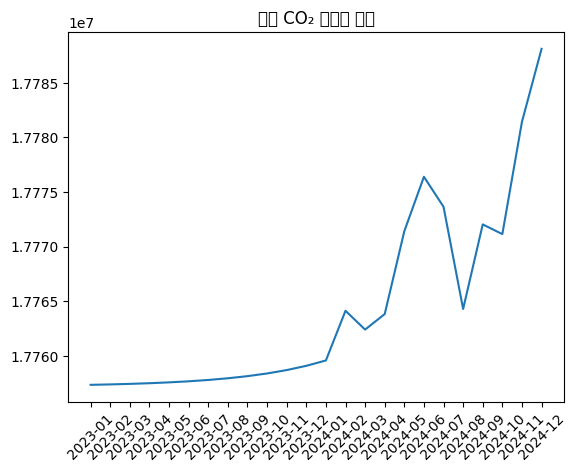

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54665 (\N{HANGUL SYLLABLE HAENG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52852 (\N{HANGUL SYLLABLE KA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

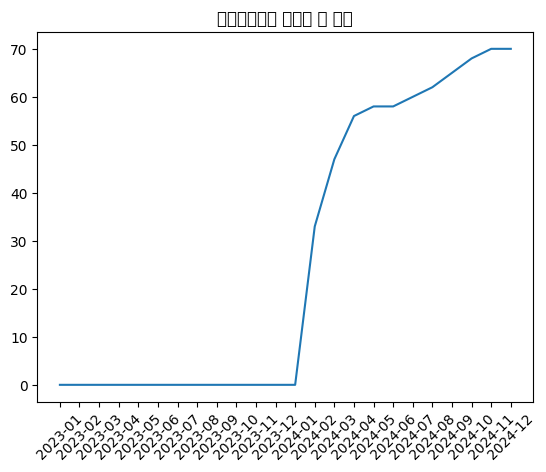

In [ ]:
import matplotlib.pyplot as plt

plt.plot(co2_df['월'], co2_df['승용_자가용_CO2_kg'])
plt.xticks(rotation=45)
plt.title("월별 CO₂ 배출량 변화")
plt.show()

plt.plot(co2_df['월'], co2_df['activation'])
plt.xticks(rotation=45)
plt.title("기후동행카드 활성화 수 변화")
plt.show()

In [ ]:
co2_df[['승용_자가용_CO2_kg', 'activation']].corr()

,승용_자가용_CO2_kg,activation
승용_자가용_CO2_kg,1.000000,0.866203
activation,0.866203,1.000000


In [ ]:
import statsmodels.formula.api as smf

# 시간 인덱스
co2_df['time_index'] = range(len(co2_df))

# 회귀모델: activation → CO₂ 영향
model = smf.ols(
    '승용_자가용_CO2_kg ~ activation + time_index',
    data=co2_df
).fit(cov_type='HC3')

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          승용_자가용_CO2_kg   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     21.42
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           8.51e-06
Time:                        07:09:01   Log-Likelihood:                -233.54
No. Observations:                  24   AIC:                             473.1
Df Residuals:                      21   BIC:                             476.6
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.775e+07   1803.171   9846.487      0.0

추세 제거 후 회귀

In [ ]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 월 기준 정렬
co2_df = co2_df.sort_values('월')

# 1차 차분
co2_df['d_co2'] = co2_df['승용_자가용_CO2_kg'].diff()
co2_df['d_activation'] = co2_df['activation'].diff()

# 차분 후 첫 번째 행 제거
df_diff = co2_df.dropna().copy()

# 차분 회귀모델
diff_model = smf.ols("d_co2 ~ d_activation", data=df_diff).fit(cov_type='HC3')

print(diff_model.summary())


                            OLS Regression Results                            
Dep. Variable:                  d_co2   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.034
Method:                 Least Squares   F-statistic:                    0.1540
Date:                Thu, 11 Dec 2025   Prob (F-statistic):              0.699
Time:                        07:16:01   Log-Likelihood:                -223.44
No. Observations:                  23   AIC:                             450.9
Df Residuals:                      21   BIC:                             453.2
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1140.2969    946.059      1.205   

ARIMAX 모델

In [ ]:
import statsmodels.api as sm

# 월을 datetime으로 사용 (확실히 정렬)
co2_df = co2_df.sort_values("월")
co2_df.index = pd.to_datetime(co2_df['월'])

# 종속변수
y = co2_df['승용_자가용_CO2_kg']

# 외생변수(기후동행카드 활성화 수)
exog = co2_df[['activation']]

# ARIMAX 모델 설정 (1,1,1 예시 — AIC 보고 조정 필요)
model_arimax = sm.tsa.SARIMAX(
    y,
    order=(1,1,1),
    exog=exog,
    enforce_stationarity=False,
    enforce_invertibility=False
)

result = model_arimax.fit()
print(result.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:          승용_자가용_CO2_kg   No. Observations:                   24
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -205.622
Date:                Thu, 11 Dec 2025   AIC                            419.244
Time:                        07:18:20   BIC                            423.422
Sample:                    01-01-2023   HQIC                           420.151
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
activation   122.2045    388.509      0.315      0.753    -639.258     883.667
ar.L1          0.0004      2.205      0.000      1.000      -4.321       4.321
ma.L1          0.0812      2.192      0.037      0.9